In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

final_df = pd.read_csv("benchmark_results_enhanced.csv")

# Assuming you already have a DataFrame 'grouped_output'
df = final_df.copy()

# Check basic info
print(df.describe())
print(df.dtypes)


       context_length  target_output_length  actual_output_length  \
count      120.000000            120.000000            120.000000   
mean     10752.000000            174.000000            174.000000   
std      11134.571917            174.810341            174.810341   
min       1024.000000             20.000000             20.000000   
25%       2048.000000             50.000000             50.000000   
50%       6144.000000            100.000000            100.000000   
75%      16384.000000            200.000000            200.000000   
max      32768.000000            500.000000            500.000000   

       prefill_latency_sec  decode_latency_sec  total_latency_sec  \
count           120.000000          120.000000         120.000000   
mean              9.062707           16.969680          26.032387   
std              20.229821           29.087942          42.935862   
min               0.016078            0.263200           0.280859   
25%               0.017735       

In [3]:

# Key Questions to Address
# Performance Scaling Across Context Lengths

# How does CPU decode throughput scale as context length increases, and how does this compare directly to GPU decode?
# At what context lengths does CPU decode become more relatively efficient compared to GPU decode?
# Output Length Effects

# How does CPU decode throughput vary with different target output lengths? Are longer outputs more favorable for CPU decoding because overhead is amortized?
# Memory and Utilization Trade-offs

# Is CPU decoding enabling larger context lengths at the cost of CPU/GPU memory usage?
# Can we quantify the trade-off in terms of memory usage per token or memory usage per throughput unit?
# Latency Profiles

# Beyond average throughput (tokens_per_second), how does CPU decode offloading affect tail latencies (p90, p99)?
# Does CPU decoding stabilize latency across large context lengths compared to GPU decoding?
# Ratios and Relative Comparisons

# Create a ratio of CPU decode performance to GPU decode performance. Investigate how this ratio changes with context length and output length.
# Explore whether certain configurations (e.g., offloaded KV cache vs. dynamic) yield better CPU/GPU throughput ratios.

In [4]:
print(df['use_cpu_decode'].value_counts())
print(df['strategy'].unique())


use_cpu_decode
False    60
True     60
Name: count, dtype: int64
['dynamic' 'offloaded']


In [5]:
# Create a pivot table to align CPU and GPU runs by context_length and target_output_length
pivot = df.pivot_table(
    values='tokens_per_second',
    index=['context_length', 'target_output_length', 'strategy'],
    columns='use_cpu_decode', 
    aggfunc='mean'
)

# Rename columns for clarity: False = GPU decode, True = CPU decode
pivot.columns = ['gpu_decode_tps', 'cpu_decode_tps']

# Drop rows where we don't have both CPU and GPU measurements
pivot = pivot.dropna()

# Compute ratio
pivot['cpu_to_gpu_ratio'] = pivot['cpu_decode_tps'] / pivot['gpu_decode_tps']

print(pivot.head())


                                               gpu_decode_tps  cpu_decode_tps  \
context_length target_output_length strategy                                    
1024           20                   dynamic         73.200803        8.042681   
                                    offloaded       69.581880        7.881209   
               50                   dynamic         78.733474        7.999631   
                                    offloaded       69.912688        7.903798   
               100                  dynamic         76.757720        8.035968   

                                               cpu_to_gpu_ratio  
context_length target_output_length strategy                     
1024           20                   dynamic            0.109871  
                                    offloaded          0.113265  
               50                   dynamic            0.101604  
                                    offloaded          0.113052  
               100                  

In [14]:
pivot

gpu_decode_tps  cpu_decode_tps  \
context_length target_output_length strategy                                    
1024           20                   dynamic         73.200803        8.042681   
                                    offloaded       69.581880        7.881209   
               50                   dynamic         78.733474        7.999631   
                                    offloaded       69.912688        7.903798   
               100                  dynamic         76.757720        8.035968   
                                    offloaded       70.069758        7.916761   
               200                  dynamic         78.233561        7.968799   
                                    offloaded       68.687231        7.880448   
               500                  dynamic         78.119880        8.117107   
                                    offloaded       70.391077        7.771341   
2048           20                   dynamic         75.987727        7.843447   
                                    offloaded       65.679827        8.026620   
               50                   dynamic         77.444324        7.832208   
                                    offloaded       68.475501        8.071291   
               100                  dynamic         77.778628        8.022284   
                                    offloaded       69.581731        8.048871   
               200                  dynamic         76.116977        7.895741   
                                    offloaded       70.035105        7.734911   
               500                  dynamic         78.240096        8.065560   
                                    offloaded       70.262019        8.023169   
4096           20                   dynamic         70.242487        7.982012   
                                    offloaded       61.769413        7.876400   
               50                   dynamic         74.995680        7.938976   
                                    offloaded       66.688543        7.552837   
               100                  dynamic         76.627357        7.906923   
                                    offloaded       68.632722        7.405594   
               200                  dynamic         76.473505        7.789791   
                                    offloaded       68.870361        7.476753   
               500                  dynamic         77.350683        7.623366   
                                    offloaded       68.821564        7.541984   
8192           20                   dynamic         53.503889        6.952067   
                                    offloaded       47.961294        6.596769   
               50                   dynamic         66.057423        6.991970   
                                    offloaded       58.609724        6.949212   
               100                  dynamic         71.056981        6.652507   
                                    offloaded       63.397763        7.001780   
               200                  dynamic         75.598842        6.584652   
                                    offloaded       65.744662        6.954879   
               500                  dynamic         77.332105        6.447899   
                                    offloaded       64.895919        6.430246   
16384          20                   dynamic         29.465571        5.531163   
                                    offloaded       25.434188        5.231261   
               50                   dynamic         47.647327        5.509901   
                                    offloaded       35.119128        5.255755   
               100                  dynamic         59.314726        5.252896   
                                    offloaded       41.073829        4.829268   
               200                  dynamic         67.629672        5.247618   
                                    offloaded       44.567305        5.209701 

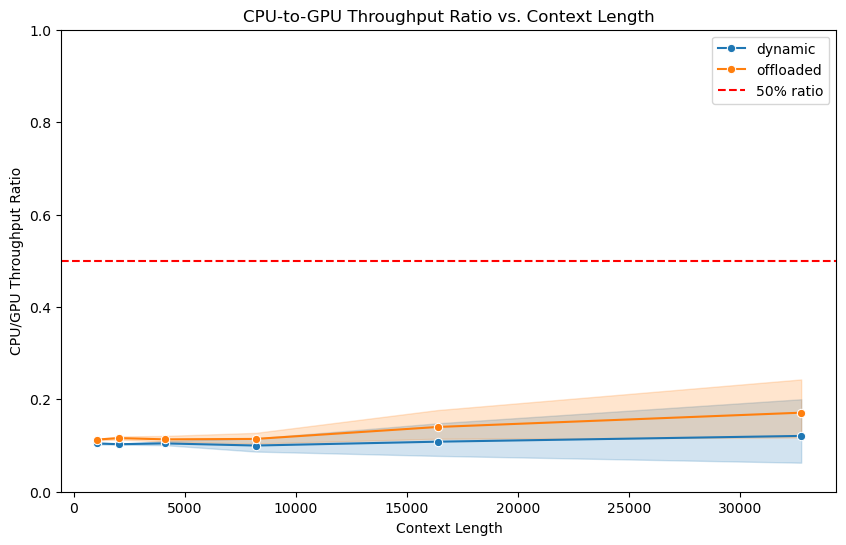

In [6]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=pivot.reset_index(),
    x='context_length',
    y='cpu_to_gpu_ratio',
    hue='strategy',  # If you have multiple KV cache strategies
    marker='o'
)
plt.title("CPU-to-GPU Throughput Ratio vs. Context Length")
plt.xlabel("Context Length")
plt.ylabel("CPU/GPU Throughput Ratio")
plt.ylim(0, 1) # since ratio likely less than 1
plt.axhline(0.5, color='r', linestyle='--', label='50% ratio')
plt.legend()
plt.show()


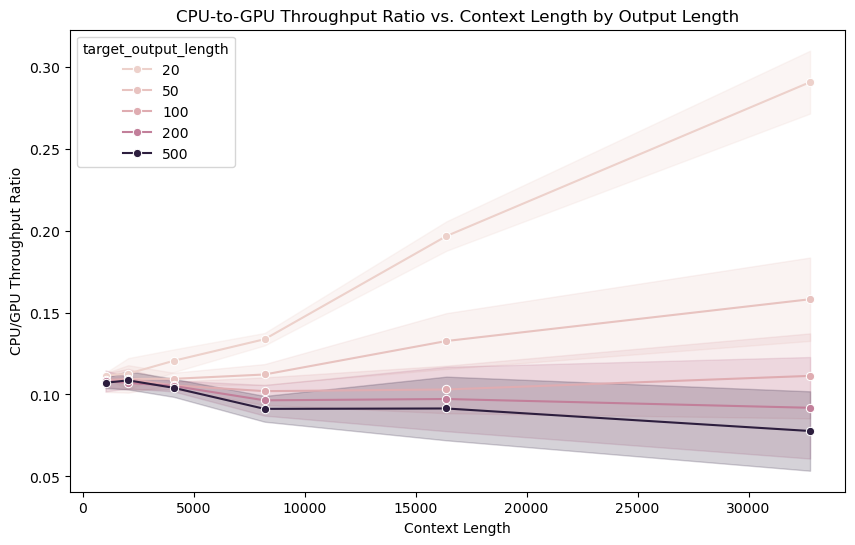

In [7]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=pivot.reset_index(),
    x='context_length',
    y='cpu_to_gpu_ratio',
    hue='target_output_length',
    marker='o'
)
plt.title("CPU-to-GPU Throughput Ratio vs. Context Length by Output Length")
plt.xlabel("Context Length")
plt.ylabel("CPU/GPU Throughput Ratio")
plt.show()


In [8]:
cols_memory = ['final_cpu_memory_mb', 'final_gpu_allocated_mb', 'final_gpu_reserved_mb']
df_memory = df[['use_cpu_decode', 'context_length', 'target_output_length', 'strategy'] + cols_memory + ['tokens_per_second']]

# Group by decode strategy and context length, and look at memory-to-throughput ratio
mem_summary = df_memory.groupby(['use_cpu_decode', 'strategy', 'context_length'])[cols_memory + ['tokens_per_second']].mean().reset_index()

# Compute memory per token/second as a rough efficiency measure
for c in cols_memory:
    mem_summary[c + '_per_tps'] = mem_summary[c] / mem_summary['tokens_per_second']
    
print(mem_summary.head())


   use_cpu_decode strategy  context_length  final_cpu_memory_mb  \
0           False  dynamic            1024          3598.027344   
1           False  dynamic            2048          3598.066406   
2           False  dynamic            4096          3598.036719   
3           False  dynamic            8192          3598.251563   
4           False  dynamic           16384          3598.404687   

   final_gpu_allocated_mb  final_gpu_reserved_mb  tokens_per_second  \
0             2378.324414                 2446.0          77.009088   
1             2384.424023                 2540.4          77.113550   
2             2396.576367                 2777.6          75.137942   
3             2421.236133                 3546.0          68.709848   
4             2469.477344                 5380.0          55.602101   

   final_cpu_memory_mb_per_tps  final_gpu_allocated_mb_per_tps  \
0                    46.722114                       30.883685   
1                    46.659327        

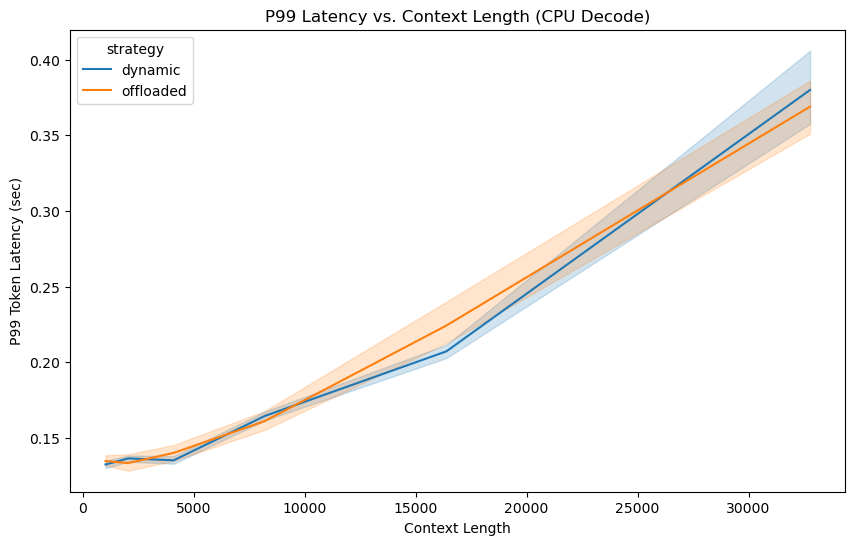

In [11]:
latency_cols = ['mean_token_latency_sec', 'p90_token_latency_sec', 'p99_token_latency_sec']
df_latency = df[['use_cpu_decode', 'context_length', 'target_output_length', 'strategy'] + latency_cols]

latency_summary = df_latency.groupby(['use_cpu_decode', 'strategy', 'context_length', 'target_output_length'])[latency_cols].mean().reset_index()

# Visualize latency as context grows
plt.figure(figsize=(10,6))
sns.lineplot(
    data=latency_summary[latency_summary['use_cpu_decode']==True],
    x='context_length',
    y='p99_token_latency_sec',
    hue='strategy'
)
plt.title("P99 Latency vs. Context Length (CPU Decode)")
plt.xlabel("Context Length")
plt.ylabel("P99 Token Latency (sec)")
plt.show()


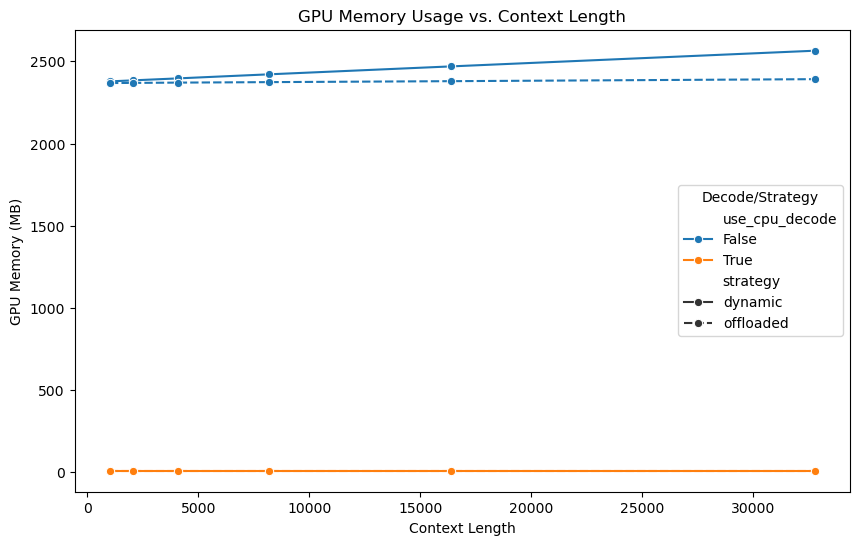

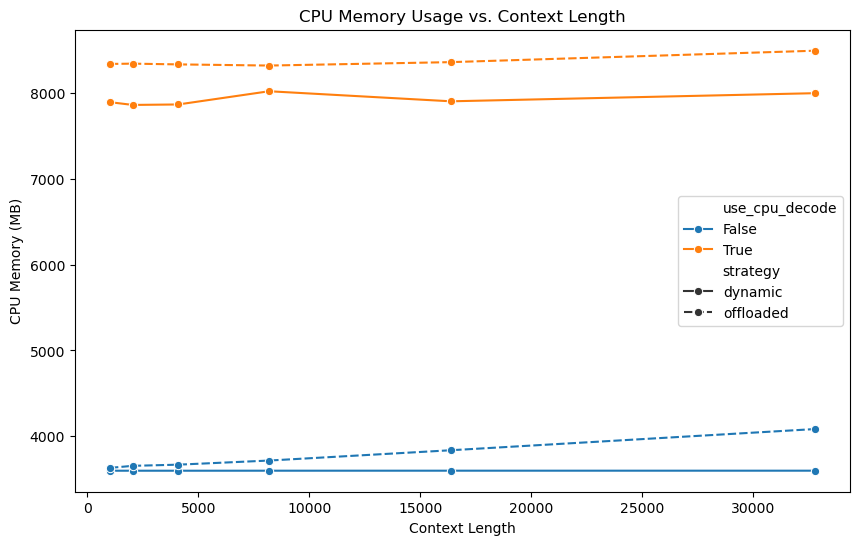

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# mem_summary structure (as previously defined) 
# Includes columns: [use_cpu_decode, strategy, context_length, tokens_per_second, final_cpu_memory_mb, final_gpu_allocated_mb, final_gpu_reserved_mb, etc.]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mem_summary,
    x='context_length',
    y='final_gpu_allocated_mb',
    hue='use_cpu_decode',  # True/False for CPU vs GPU decode
    style='strategy',
    marker='o'
)
plt.title("GPU Memory Usage vs. Context Length")
plt.xlabel("Context Length")
plt.ylabel("GPU Memory (MB)")
plt.legend(title='Decode/Strategy')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=mem_summary,
    x='context_length',
    y='final_cpu_memory_mb',
    hue='use_cpu_decode',
    style='strategy',
    marker='o'
)
plt.title("CPU Memory Usage vs. Context Length")
plt.xlabel("Context Length")
plt.ylabel("CPU Memory (MB)")
plt.show()


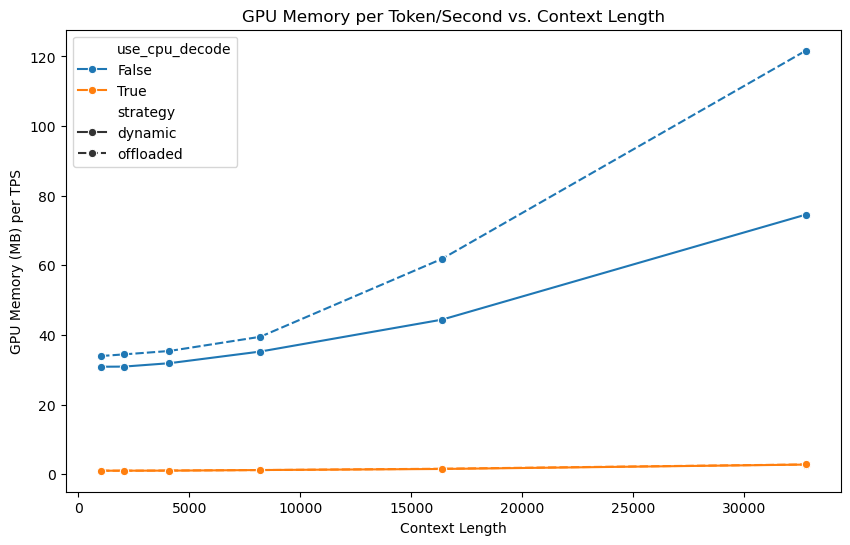

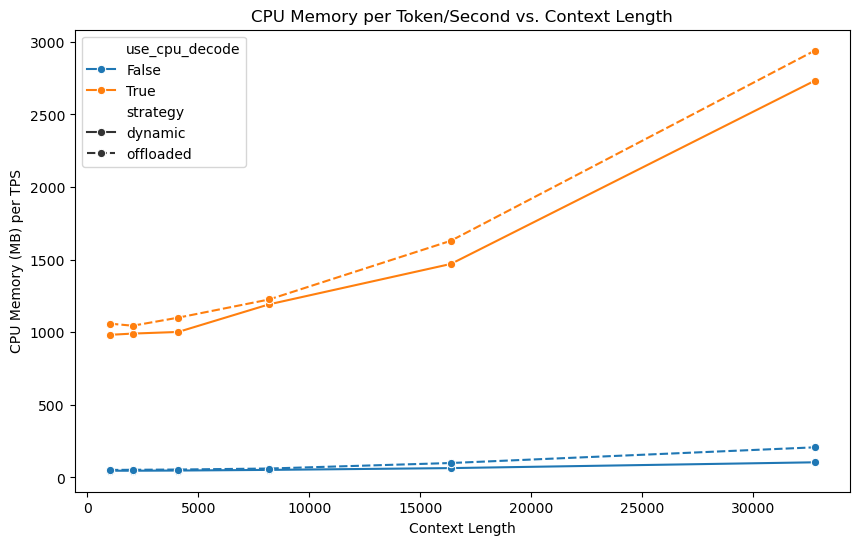

In [16]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=mem_summary,
    x='context_length',
    y='final_gpu_allocated_mb_per_tps',
    hue='use_cpu_decode',
    style='strategy',
    marker='o'
)
plt.title("GPU Memory per Token/Second vs. Context Length")
plt.xlabel("Context Length")
plt.ylabel("GPU Memory (MB) per TPS")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=mem_summary,
    x='context_length',
    y='final_cpu_memory_mb_per_tps',
    hue='use_cpu_decode',
    style='strategy',
    marker='o'
)
plt.title("CPU Memory per Token/Second vs. Context Length")
plt.xlabel("Context Length")
plt.ylabel("CPU Memory (MB) per TPS")
plt.show()


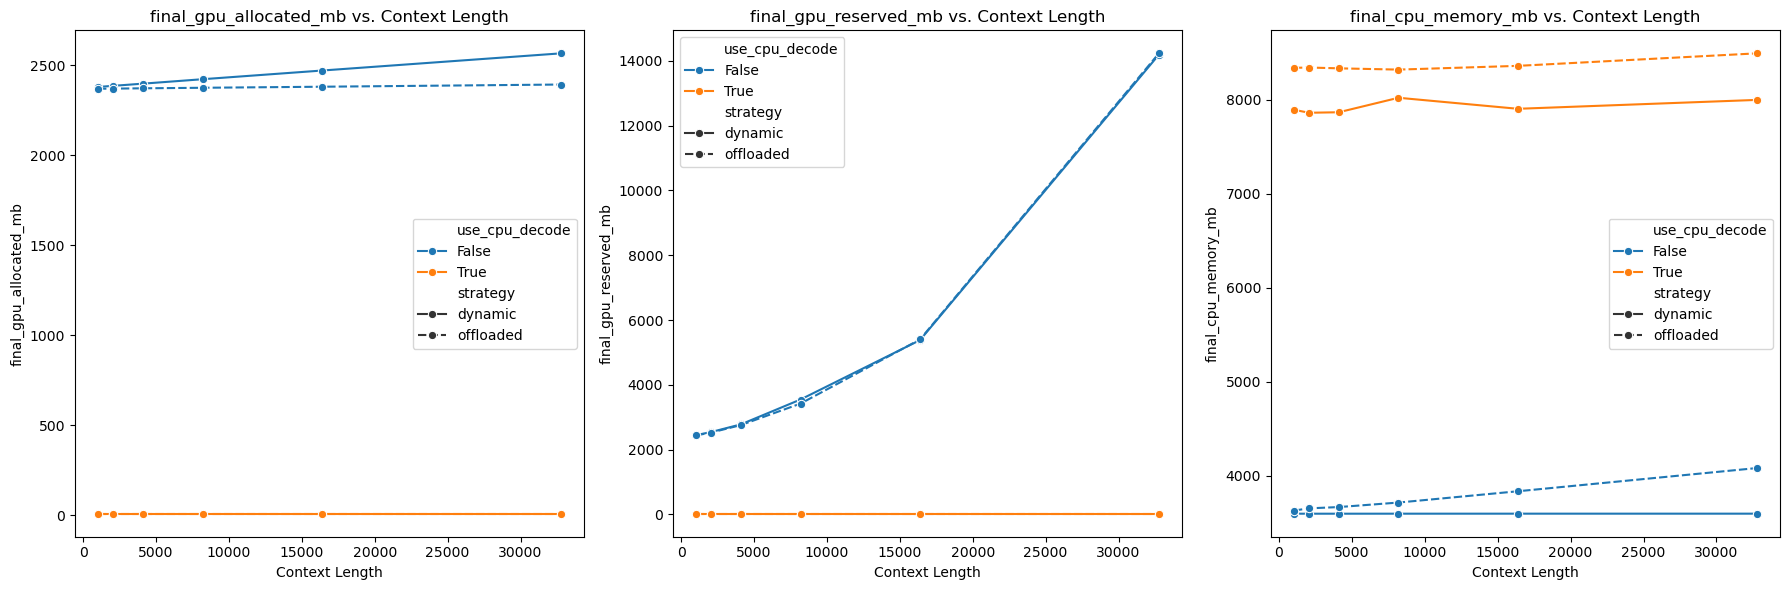

In [17]:
metrics = ['final_gpu_allocated_mb', 'final_gpu_reserved_mb', 'final_cpu_memory_mb']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

for ax, metric in zip(axes, metrics):
    sns.lineplot(
        data=mem_summary,
        x='context_length',
        y=metric,
        hue='use_cpu_decode',
        style='strategy',
        marker='o',
        ax=ax
    )
    ax.set_title(f"{metric} vs. Context Length")
    ax.set_xlabel("Context Length")
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()


In [19]:
critical_contexts = df[df['context_length'].isin([16384, 32768])]
summary = critical_contexts.groupby(['use_cpu_decode', 'strategy'])[
    ['final_gpu_allocated_mb', 'final_cpu_memory_mb', 'tokens_per_second']
].mean()

print(summary)

                          final_gpu_allocated_mb  final_cpu_memory_mb  \
use_cpu_decode strategy                                                 
False          dynamic               2517.193848          3598.427734   
               offloaded             2385.649512          3960.028516   
True           dynamic                  8.125000          7950.414453   
               offloaded                8.125000          8426.186719   

                          tokens_per_second  
use_cpu_decode strategy                      
False          dynamic            45.000163  
               offloaded          29.057241  
True           dynamic             4.150584  
               offloaded           4.008470  
